# Simulating Unsupervised Image Classification in Label-Scarce Environments

In this Jupyter notebook, I attempt to perform MNIST image classification by minimizing the number of calls to labels for images, in order to simulate working an an environment that is scarce of labeled data.

First, I use a deep auto-encoder architecture to compress the $768$-dimensional representation of MNIST images to $32$ dimensions and to extract features.

Then, I iteratively perform $k$-means clustering. In a certain iteration where we divide the data into $k$ clusters, I find the medoid of each cluster. The medoid of a cluster is the closest datapoint in the dataset to the centroid ("average" or numerical center) of that cluster. I query the medoid's label and assign that label to the entire cluster. I specifically query for the medoid's label in a cluster, because datapoints closer to the fringes have a higher chance of being misclassified; the medoid's label is more likely to be representative of the cluster.

If for a certain $k$, the desired accuracy is not reached, then $k$ is doubled and we run $k$-means clustering again. The reason why we geometrically increase $k$ (doubling) instead of arithmetically increasing $k$ (adding a fixed value to $k$ in each iteration), because as follows: Let us say that the optimal $k$ where the accuracy is just above or equal to $0.9$ is $k'$. Then, the total images queried is as follows:

$\sum_{i=1}^{\log_2{k'}} 2^i = 1 + 2 + 4 + \ldots + k' = 2k' - 1$.

In other words, the total images queried will be approximately twice compared to if we knew that $k'$ was the optimal $k$ before-hand (and we could just set $k=k'$ and query for $k'$ images from the start). This is a good bound.

In total, I queried for $310$ images' labels. This means that $\frac{60000-310}{60000}=99.5\%$ of the dataset doesn't need to be labeled.

# Loading MNIST

In [18]:
from keras.datasets import mnist
import numpy as np
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

print(x_train.shape)
print(x_test.shape)

(60000, 784)
(10000, 784)


# Using an Auto-encoder to Reduce Dimensionality of Image Vectors

In [46]:
import keras
from keras import layers

input_img = keras.Input(shape=(784,))

encoded = layers.Dense(256, activation='relu')(input_img)
encoded = layers.Dense(128, activation='relu')(encoded)
encoded = layers.Dense(64, activation='relu')(encoded)
encoded = layers.Dense(32, activation='relu')(encoded)

decoded = layers.Dense(64, activation='relu')(encoded)
decoded = layers.Dense(128, activation='relu')(decoded)
decoded = layers.Dense(256, activation='relu')(decoded)
decoded = layers.Dense(784, activation='sigmoid')(decoded)

In [47]:
# Autoencoder (encoder -> decoder)
autoencoder = keras.Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

# Encoder
encoder = keras.Model(input_img, encoded)

# Training
autoencoder.fit(x_train, x_train,
                epochs=100,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test))

Epoch 1/100
235/235 [==============================] - 2s 6ms/step - loss: 0.3173 - val_loss: 0.1599
Epoch 2/100
235/235 [==============================] - 1s 5ms/step - loss: 0.1514 - val_loss: 0.1336
Epoch 3/100
235/235 [==============================] - 1s 4ms/step - loss: 0.1316 - val_loss: 0.1225
Epoch 4/100
235/235 [==============================] - 1s 5ms/step - loss: 0.1218 - val_loss: 0.1150
Epoch 5/100
235/235 [==============================] - 1s 5ms/step - loss: 0.1148 - val_loss: 0.1110
Epoch 6/100
235/235 [==============================] - 1s 5ms/step - loss: 0.1102 - val_loss: 0.1065
Epoch 7/100
235/235 [==============================] - 1s 4ms/step - loss: 0.1067 - val_loss: 0.1033
Epoch 8/100
235/235 [==============================] - 1s 4ms/step - loss: 0.1041 - val_loss: 0.1017
Epoch 9/100
235/235 [==============================] - 1s 4ms/step - loss: 0.1014 - val_loss: 0.0991
Epoch 10/100
235/235 [==============================] - 1s 4ms/step - loss: 0.0994 - val_lo

In [48]:
x_train_comp = encoder.predict(x_train)
x_test_comp = encoder.predict(x_test)

print(x_train_comp.shape)
print(x_test_comp.shape)

(60000, 32)
(10000, 32)


In [49]:
img_to_label = dict()

for i in range(x_train_comp.shape[0]):
  img_to_label[str(x_train_comp[i])] = y_train[i]

for i in range(x_test_comp.shape[0]):
  img_to_label[str(x_test_comp[i])] = y_test[i]

print(len(img_to_label))

70000


# Iterative K-Means Clustering

In [51]:
from sklearn.cluster import KMeans
from sklearn.metrics import mean_squared_error, accuracy_score
import numpy as np

print('K\tAccuracy')

k = 10
accs = [] # List of tuples (k, accuracy)
while True:
  # Run k-means clustering with k clusterss
  kmeans = KMeans(n_clusters=k, random_state=0).fit(x_train_comp)

  # Assign label to each cluster based on the medoid of the cluster
  cluster_to_label = dict()
  for cluster in range(k):
    centroid = kmeans.cluster_centers_[cluster]
    cluster_imgs = x_train_comp[np.where(kmeans.labels_ == cluster)]
    cluster_dists = [mean_squared_error(centroid, img) for img in cluster_imgs]
    cluster_dist_min = min(cluster_dists)
    medoid_idx = cluster_dists.index(cluster_dist_min)
    medoid_img = cluster_imgs[medoid_idx]
    medoid_label = img_to_label[str(medoid_img)]
    cluster_to_label[cluster] = medoid_label

  # Predict labels and get accuracy
  cluster_labels = kmeans.predict(x_test_comp)
  preds = np.array(list(map(lambda n: cluster_to_label[n], cluster_labels)))
  acc = accuracy_score(y_test, preds)

  accs.append((k, acc))
  print(str(k) + '\t' + str(acc))

  if acc < 0.9:
    k *= 2 # Double number of clusters with each iteration
  else:
    break

K	Accuracy
10	0.5652
20	0.708
40	0.7996
80	0.8785
160	0.9045


In [52]:
imgs_queried = sum([t[0] for t in accs])
print(imgs_queried)

310


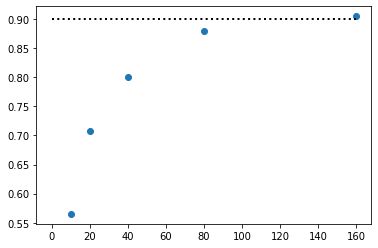

In [55]:
import matplotlib.pyplot as plt

xs = list(map(lambda t: t[0], accs))
ys = list(map(lambda t: t[1], accs))

plt.scatter(xs, ys)
plt.plot([0, accs[-1][0]], [0.9, 0.9], 'k:', lw=2)
plt.show()